In [4]:
import pickle
import numpy as np
import numpy.random as npr
import glob
import os
import matplotlib.pyplot as plt
import importlib
import json

In [5]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
torch.cuda.set_device(2)
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
4
2
cuda


In [6]:
import out_of_distribution_detection as ood
importlib.reload(ood)

representations_dir_path = './data/representations/wide_resnet101/'
files_list = os.listdir(representations_dir_path)

for file in files_list:
    X = np.load(representations_dir_path+file)    
    print(file, X.shape)

Places.npy (10000, 1000)
SUN.npy (9997, 1000)
agricultural_crops.npy (255, 1000)
excavation.npy (398, 1000)
alzeihmer.npy (6400, 1000)
animation_faces.npy (43102, 1000)
arabic_handwritten_characters.npy (33600, 1000)
blood_cells.npy (874, 1000)
brainMRITumorTypes.npy (3264, 1000)
brand_logos.npy (145, 1000)
captcha.npy (60, 1000)
cards.npy (8154, 1000)
chess_pieces.npy (651, 1000)
chest_xray_pneumonia.npy (5856, 1000)
chinese_fine_art.npy (395, 1000)
weedcrop.npy (2822, 1000)
paintings.npy (500, 1000)
coffee_beans.npy (1600, 1000)
plant_disease.npy (1532, 1000)
diamonds.npy (6132, 1000)
emotional_faces.npy (32298, 1000)
english_handwritten_chars.npy (3410, 1000)
colonoscopy.npy (612, 1000)
eyes.npy (2815, 1000)
faces_in_the_wild.npy (13233, 1000)
fastfood.npy (19775, 1000)
female_male_eyes.npy (11525, 1000)
fire_and_smoke.npy (100, 1000)
gemstones.npy (3219, 1000)
meat_quality.npy (1896, 1000)
handwritten_math_symbols.npy (7703, 1000)
homer_and_bart.npy (269, 1000)
iNaturalist.npy (100

# max of ID samples in the dual divergence space as a cut point

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

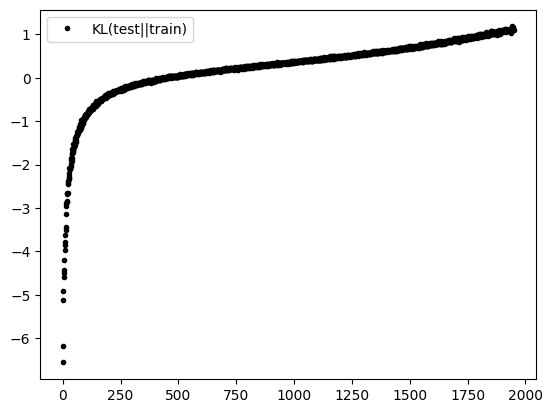

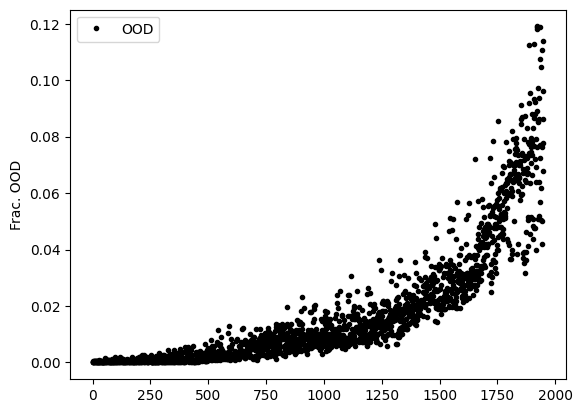

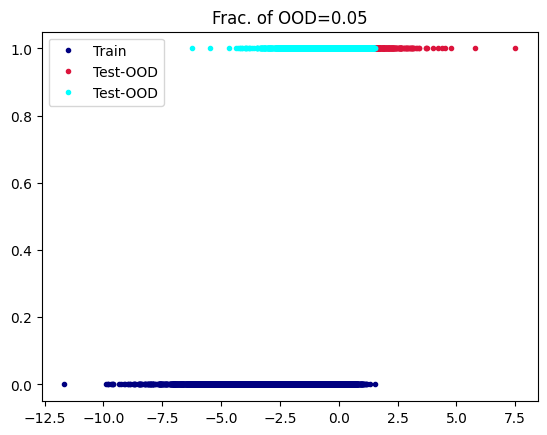

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

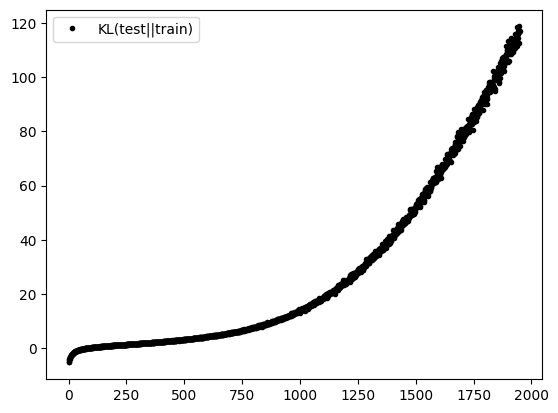

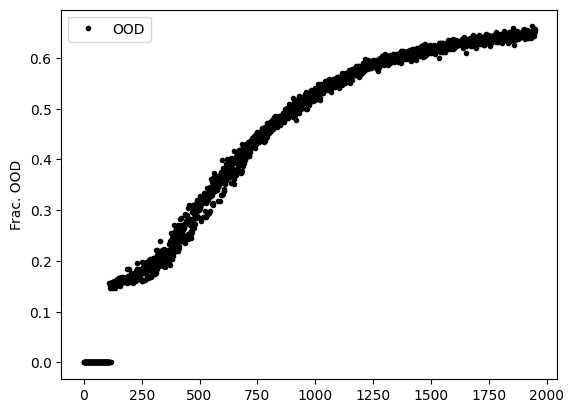

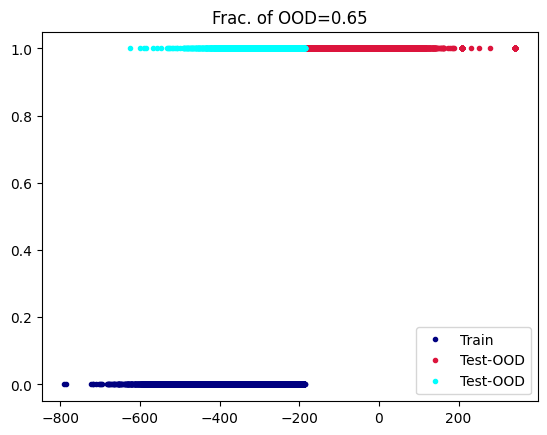

Val. ID=0.05174611266887586, Val. OOD=0.6481111111111111
Places.npy 0.1604
SUN.npy 0.1582474742422727
agricultural_crops.npy 0.0
excavation.npy 0.0
alzeihmer.npy 0.003593749999999951
animation_faces.npy 0.04742239339241794
arabic_handwritten_characters.npy 0.017946428571428585
blood_cells.npy 0.003432494279176246
brainMRITumorTypes.npy 0.015931372549019662
brand_logos.npy 0.0
captcha.npy 0.0
cards.npy 0.08376257051753744
chess_pieces.npy 0.006144393241167445
chest_xray_pneumonia.npy 0.022711748633879814
chinese_fine_art.npy 0.0025316455696202667
weedcrop.npy 0.010630758327427325
paintings.npy 0.0020000000000000018
coffee_beans.npy 0.0031250000000000444
plant_disease.npy 0.01631853785900783
diamonds.npy 0.011904761904761862
emotional_faces.npy 0.04303672053997154
english_handwritten_chars.npy 0.0035190615835777317
colonoscopy.npy 0.0016339869281045694
eyes.npy 0.006749555950266384


In [ ]:
import out_of_distribution_detection as ood
importlib.reload(ood)

X_id_trn = np.load(representations_dir_path+'image_net.npy')
X_in_val = np.load(representations_dir_path+'image_net_val.npy')
X_val_ood = np.load(representations_dir_path+'validation.npy')

# hyperparameters manually tuned such that there is false OOD detection rate of 5% within the ID set, while maximizing the OOD detection rate for OOD validation date (which is created from ID set as it is standard practice)
dist_drift_kl_est = ood.DistributionalDriftEstimator(
            seed=0, debug=True,
            dropout=0.0,
            hidden_size=64,
            std=0.15,
            num_hidden_layers=3,
            num_iter=1950,
            lr=1e-4,
            batch_size=10000,
            is_smooth_max=False,
)

ood_id = dist_drift_kl_est.ood_detection_from_dual_divergence_estimation(
    X_train=X_id_trn.copy(),
    X_test=X_in_val.copy(),
    device=device,
)[0]

ood_ood = dist_drift_kl_est.ood_detection_from_dual_divergence_estimation(
    X_train=X_id_trn.copy(),
    X_test=X_val_ood.copy(),
    device=device,
)[0]

print(f'Val. ID={ood_id}, Val. OOD={ood_ood}')

# independent test evaluation

files_list = os.listdir(representations_dir_path)
files_list.remove('image_net.npy')
files_list.remove('image_net_val.npy')
files_list.remove('validation.npy')
fpr_95 = np.zeros(len(files_list))

dist_drift_kl_est.debug = False
ood_map = {}
for i, file in enumerate(files_list):
    X = np.load(representations_dir_path+file)  
    fpr_95[i] = 1.0 - dist_drift_kl_est.ood_detection_from_dual_divergence_estimation(
        X_train=X_id_trn.copy(),
        X_test=X.copy(),
    )[0]   
    ood_map[file.strip('.npy')] = fpr_95[i]
    print(file, ood_map[file.strip('.npy')])

print(fpr_95.mean(), fpr_95.std())
    
results_dir_path = './ood_results/wide_resnet101/'
with open(results_dir_path+'kl_div_dv_dual_max_approx.json', 'w') as f:
    json.dump(ood_map, f, indent=4)

# softmax of ID samples in the dual divergence space as a cut point

In [ ]:
import out_of_distribution_detection as ood
importlib.reload(ood)

X_id_trn = np.load(representations_dir_path+'image_net.npy')
X_in_val = np.load(representations_dir_path+'image_net_val.npy')
X_val_ood = np.load(representations_dir_path+'validation.npy')

# hyperparameters manually tuned such that there is false OOD detection rate of 5% within the ID set, while maximizing the OOD detection rate for OOD validation date (which is created from ID set as it is standard practice)
dist_drift_kl_est = ood.DistributionalDriftEstimator(
            seed=0, debug=True,
            dropout=0.0,
            hidden_size=64,
            std=0.15,
            num_hidden_layers=3,
            num_iter=3350,
            lr=1e-4,
            batch_size=10000,
            is_smooth_max=True,
)

ood_id = dist_drift_kl_est.ood_detection_from_dual_divergence_estimation(
    X_train=X_id_trn.copy(),
    X_test=X_in_val.copy(),
    device=device,
)[0]

ood_ood = dist_drift_kl_est.ood_detection_from_dual_divergence_estimation(
    X_train=X_id_trn.copy(),
    X_test=X_val_ood.copy(),
    device=device,
)[0]

print(f'Val. ID={ood_id}, Val. OOD={ood_ood}')

files_list = os.listdir(representations_dir_path)
fpr_95 = np.zeros(len(files_list))

dist_drift_kl_est.debug = False
ood_map = {}
for i, file in enumerate(files_list):
    X = np.load(representations_dir_path+file)  
    fpr_95[i] = 1.0 - dist_drift_kl_est.ood_detection_from_dual_divergence_estimation(
        X_train=X_id_trn.copy(),
        X_test=X.copy(),
    )[0]   
    ood_map[file.strip('.npy')] = fpr_95[i]
    print(file, round(ood_map[file.strip('.npy')], 3))

print(fpr_95.mean(), fpr_95.std())
    
results_dir_path = './ood_results/wide_resnet101/'
with open(results_dir_path+'kl_div_dv_dual_softmax.json', 'w') as f:
    json.dump(ood_map, f, indent=4)